In [1]:
import numpy as np
import matplotlib.pyplot as plt


2025-05-05 18:54:08.864301: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 18:54:08.876853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746460448.890332    7751 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746460448.894089    7751 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 18:54:08.910195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 2444 files belonging to 8 classes.


I0000 00:00:1746460451.355500    7751 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 391 files belonging to 8 classes.


Corrupt JPEG data: 7 extraneous bytes before marker 0xee
2025-05-05 18:54:15.332247: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-05 18:54:15.845713: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Split: 1955, 489, 391


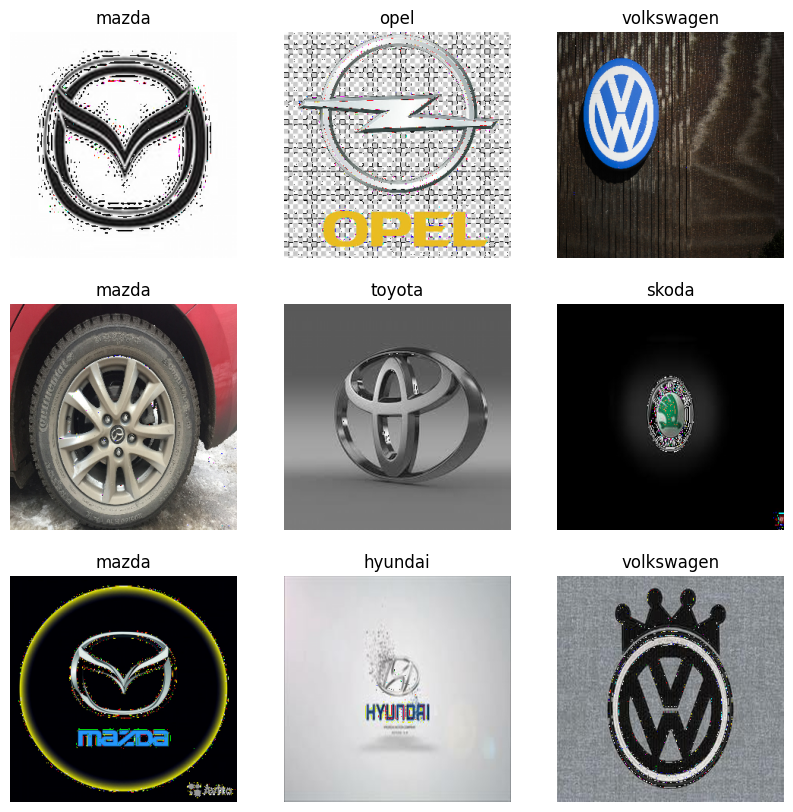

In [2]:
from keras import utils

ds = utils.image_dataset_from_directory("./dataset/Train", image_size=(299, 299), interpolation="lanczos5", seed=12151251, batch_size=None)
test_ds = utils.image_dataset_from_directory("./dataset/Test", image_size=(299, 299), interpolation="lanczos5", seed=12151251, batch_size=None)
class_names = ds.class_names

ds_count = sum(1 for _ in ds)
test_count = sum(1 for _ in test_ds)
  
train_size = 0.8
valid_size = 0.2

train_count = int(ds_count * train_size)
valid_count = int(ds_count - train_count)

print(f"Split: {train_count}, {valid_count}, {test_count}")

train_ds = ds.take(train_count).batch(32)
valid_ds = ds.skip(train_count).batch(32)
test_ds = test_ds.batch(32)

for i in range(len(class_names)):
  class_names[i] = class_names[i].split("-")[-1]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

2025-05-05 18:54:16.612152: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


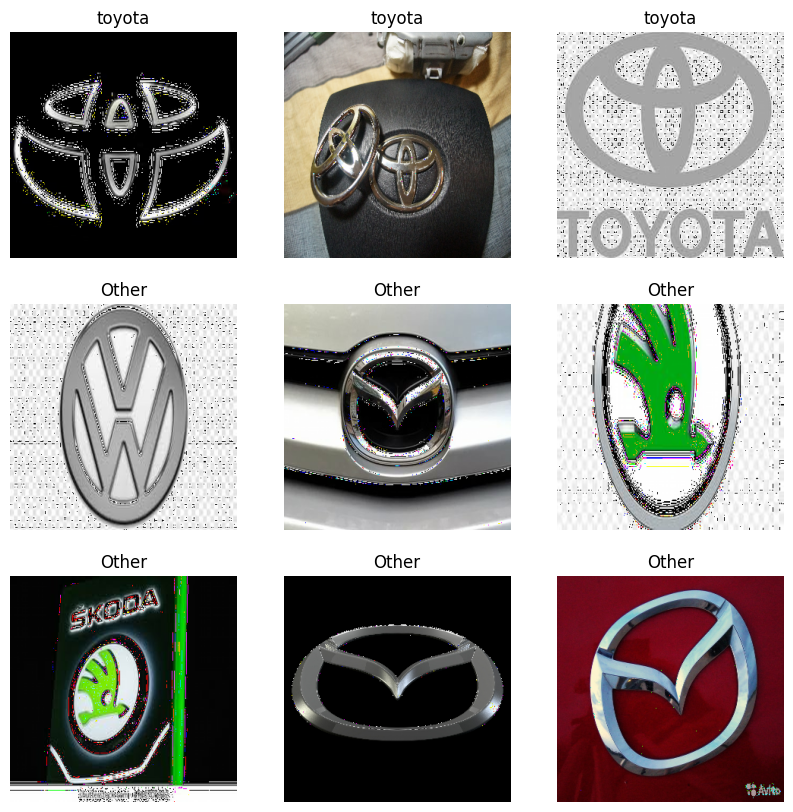

In [3]:
import tensorflow as tf

target_classname = "toyota"
assert target_classname in class_names

target_index = class_names.index(target_classname)

train_ds = train_ds.map(lambda x, y: (x, tf.cast(tf.equal(y, target_index), tf.int32)))
valid_ds = valid_ds.map(lambda x, y: (x, tf.cast(tf.equal(y, target_index), tf.int32)))
test_ds = test_ds.map(lambda x, y: (x, tf.cast(tf.equal(y, target_index), tf.int32)))

class_names = ['Other', target_classname]

plt.figure(figsize=(10, 10))
i = 0
for img, label in train_ds.unbatch().filter(lambda x, y: tf.equal(y, 1)).take(3):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy().astype("uint8"))
  plt.title(class_names[label])
  plt.axis("off")
  i += 1
  
for img, label in train_ds.unbatch().filter(lambda x, y: tf.equal(y, 0)).take(6):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy().astype("uint8"))
  plt.title(class_names[label])
  plt.axis("off")
  i += 1
    

In [4]:
from keras import models, layers, applications


def MyNet(input_shape=(299, 299, 3)):
  inputs = layers.Input(shape=input_shape)
  x = layers.Resizing(299, 299)(inputs)
  x = layers.Rescaling(1./255)(x)
  x = layers.RandomColorJitter(
    value_range=(0, 1),
    brightness_factor=0.2,
    contrast_factor=0.2,
    saturation_factor=0.2,
    hue_factor=0.2
  )(x)
  x = layers.RandomFlip(
    mode="horizontal_and_vertical"
  )(x)

  xception = applications.Xception(include_top=False, input_tensor=x)
  
  x = xception.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(4096, activation="relu")(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = models.Model(inputs=inputs, outputs=outputs)
  
  return model, xception


In [5]:
from keras import optimizers

epochs = 20

initial_learning_rate = 1e-3
final_learning_rate = 1e-6
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1 / epochs)

steps_per_epoch = train_count

learning_rate = optimizers.schedules.ExponentialDecay(
  initial_learning_rate=initial_learning_rate,
  decay_steps=steps_per_epoch,
  decay_rate=learning_rate_decay_factor
)

model, base_model = MyNet(input_shape=(299, 299, 3))

model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 299, 299,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 299, 299,  │          0 │ resizing[0][0]    │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_color_jitter │ (None, 299, 299,  │          0 │ rescaling[0][0]   │
│ (RandomColorJitter) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 299, 299,  │          0 │ random_color_jit… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ random_flip[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act

 Total params: 29,258,281 (111.61 MB)

 Trainable params: 29,203,753 (111.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [6]:
for layer in base_model.layers:
  layer.trainable = False

class_weight = {0: 1, 1: 8}

history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, class_weight=class_weight)

Epoch 1/20


I0000 00:00:1746460460.437453    7882 service.cc:148] XLA service 0x7f1ad0002ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746460460.437491    7882 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-05-05 18:54:20.522928: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746460461.130445    7882 cuda_dnn.cc:529] Loaded cuDNN version 90300
Corrupt JPEG data: 7 extraneous bytes before marker 0xee
2025-05-05 18:54:22.339472: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4059_0', 116 bytes spill stores, 216 bytes spill loads

2025-05-05 18:54:22.404963: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled

 3/62 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4149 - loss: 1.4137 

I0000 00:00:1746460469.861616    7882 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6730 - loss: 1.2050

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.6745 - loss: 1.2007 - val_accuracy: 0.8569 - val_loss: 0.2912
Epoch 2/20
28/62 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8693 - loss: 0.4700

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8665 - loss: 0.5180

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.8667 - loss: 0.5185 - val_accuracy: 0.7710 - val_loss: 0.4532
Epoch 3/20
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8576 - loss: 0.4457

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.8580 - loss: 0.4469 - val_accuracy: 0.7137 - val_loss: 0.6197
Epoch 4/20
14/62 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8695 - loss: 0.3920

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9070 - loss: 0.3686

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9070 - loss: 0.3693 - val_accuracy: 0.8548 - val_loss: 0.3073
Epoch 5/20
38/62 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9272 - loss: 0.3412

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9279 - loss: 0.3317

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.9276 - loss: 0.3318 - val_accuracy: 0.8609 - val_loss: 0.3033
Epoch 6/20
15/62 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9505 - loss: 0.2196

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9375 - loss: 0.2527

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.9371 - loss: 0.2542 - val_accuracy: 0.7362 - val_loss: 0.6562
Epoch 7/20
11/62 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8936 - loss: 0.3062

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9243 - loss: 0.2883

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9241 - loss: 0.2896 - val_accuracy: 0.9182 - val_loss: 0.2011
Epoch 8/20
15/62 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8995 - loss: 0.2839

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9149 - loss: 0.2844

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.9151 - loss: 0.2841 - val_accuracy: 0.8855 - val_loss: 0.2469
Epoch 9/20
 8/62 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9546 - loss: 0.2473

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9567 - loss: 0.2241

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9566 - loss: 0.2239 - val_accuracy: 0.9632 - val_loss: 0.1132
Epoch 10/20
18/62 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9450 - loss: 0.2265

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9466 - loss: 0.2107

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9469 - loss: 0.2097 - val_accuracy: 0.9141 - val_loss: 0.2312
Epoch 11/20
35/62 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9560 - loss: 0.1322

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9591 - loss: 0.1327

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9592 - loss: 0.1328 - val_accuracy: 0.9387 - val_loss: 0.1268
Epoch 12/20
15/62 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9774 - loss: 0.1259

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9777 - loss: 0.1090

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9776 - loss: 0.1092 - val_accuracy: 0.9714 - val_loss: 0.0708
Epoch 13/20
22/62 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9702 - loss: 0.1078

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9691 - loss: 0.1252

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9689 - loss: 0.1265 - val_accuracy: 0.9284 - val_loss: 0.2026
Epoch 14/20
17/62 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9631 - loss: 0.1225

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9635 - loss: 0.1337

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9628 - loss: 0.1377 - val_accuracy: 0.8446 - val_loss: 0.4128
Epoch 15/20
15/62 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9019 - loss: 0.2466

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9454 - loss: 0.1824

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9460 - loss: 0.1812 - val_accuracy: 0.9550 - val_loss: 0.1070
Epoch 16/20
23/62 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9777 - loss: 0.0870

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9752 - loss: 0.0995

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.9752 - loss: 0.0996 - val_accuracy: 0.9591 - val_loss: 0.0868
Epoch 17/20
31/62 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9777 - loss: 0.1301

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9717 - loss: 0.1541

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9715 - loss: 0.1549 - val_accuracy: 0.9448 - val_loss: 0.1226
Epoch 18/20
26/62 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9840 - loss: 0.0901

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9845 - loss: 0.0794

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9845 - loss: 0.0791 - val_accuracy: 0.9898 - val_loss: 0.0365
Epoch 19/20
38/62 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9720 - loss: 0.2371

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9695 - loss: 0.2181

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9694 - loss: 0.2165 - val_accuracy: 0.9632 - val_loss: 0.0948
Epoch 20/20
21/62 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9957 - loss: 0.0480

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9908 - loss: 0.0640

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9906 - loss: 0.0644 - val_accuracy: 0.9571 - val_loss: 0.1302


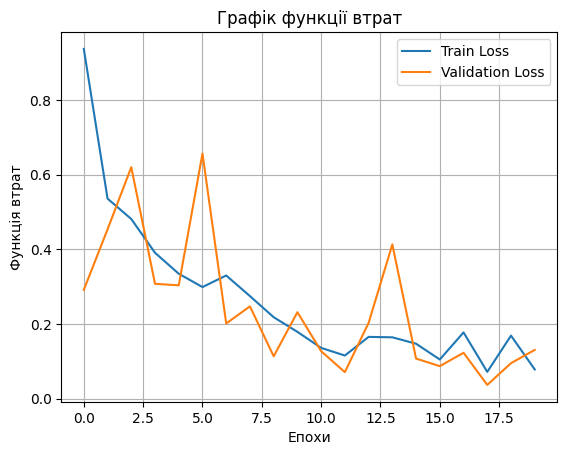

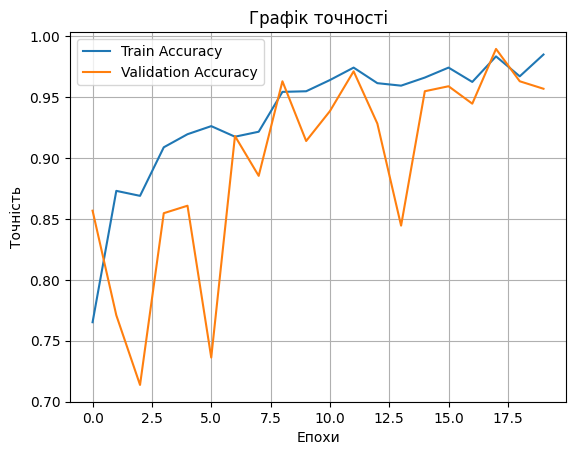

In [7]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Епохи')
plt.ylabel('Функція втрат')
plt.title('Графік функції втрат')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.title('Графік точності')
plt.legend()
plt.grid()
plt.show()

In [8]:
model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.8982 - loss: 0.2650


[0.2641780972480774, 0.905370831489563]

In [9]:
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    predictions = model.predict(x_batch)
    pred_labels = np.array(predictions).round()
    y_true.extend(y_batch.numpy())
    y_pred.extend(pred_labels)
    
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


[array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], d

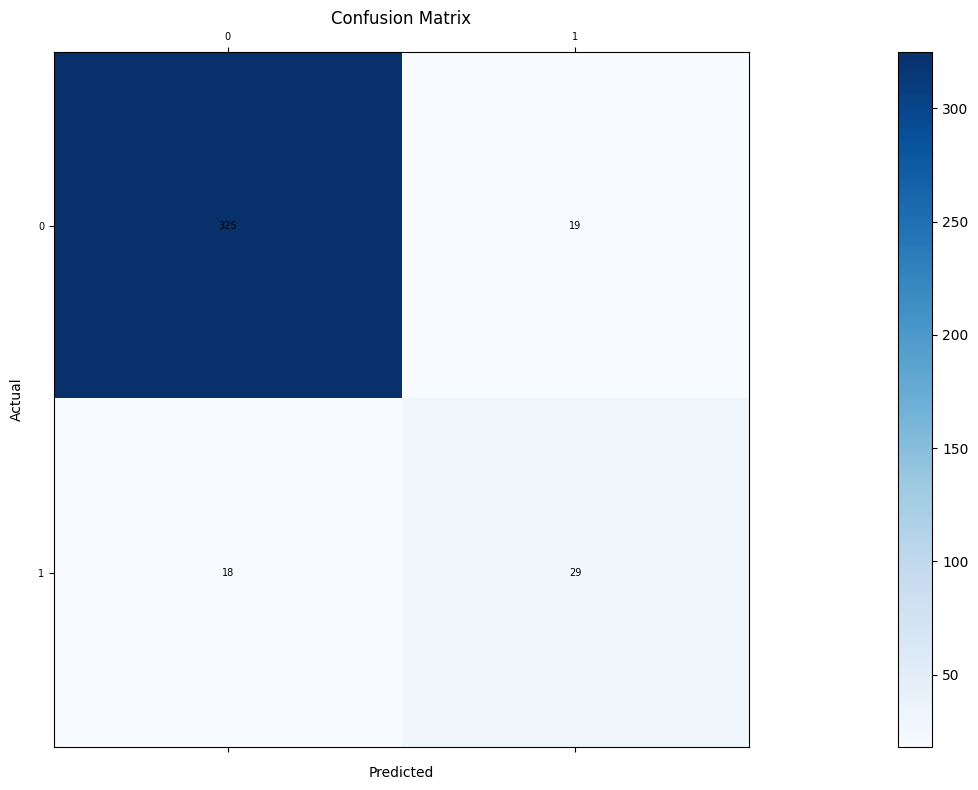

In [10]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(30, 8))
cax = ax.matshow(conf_matrix, cmap="Blues")

plt.colorbar(cax)

class_labels=range(len(class_names))

ax.set_xticks(range(len(class_labels)))
ax.set_yticks(range(len(class_labels)))
ax.set_xticklabels(class_labels, fontsize=7)
ax.set_yticklabels(class_labels, fontsize=7)

plt.title("Confusion Matrix", pad=20)
plt.xlabel("Predicted", labelpad=10)
plt.ylabel("Actual", labelpad=10)

for (i, j), value in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=7)

plt.tight_layout()
plt.show()

In [11]:
model.save("./model.keras")